System Requirements

In [61]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import mglearn
print("mglearn version: {}".format(mglearn.__version__))
%matplotlib inline

Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.2.2
matplotlib version: 3.8.4
NumPy version: 1.26.4
SciPy version: 1.13.1
scikit-learn version: 1.4.2
mglearn version: 0.2.0


# Introduction
## Activation function
- Activation functions of a node defines the output of that node given an input or set of inputs e.g. MLPClassifier supports 'relu', 'identity', 'logistic' (=sigmoid), 'tanh'.
- This activation functions makes deep learning different from simply doing iterative LR on each layer, e.g, Tanh contains the output to between -1 and 1.
- Discover which activation function is best by trial and error
<!-- https://en.wikipedia.org/wiki/Activation_function -->


Text(0, 0.5, 'f(x)')

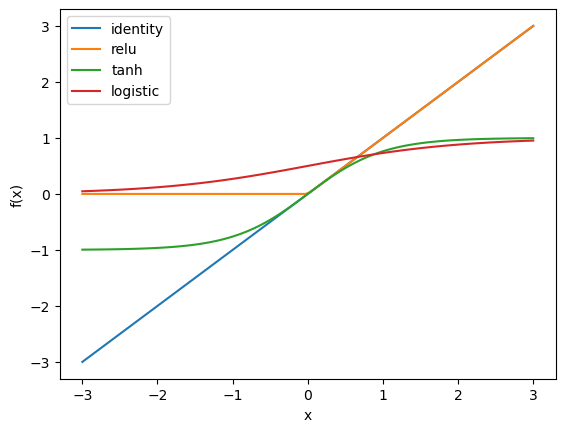

In [62]:
line = np.linspace(-3, 3, 100)
plt.plot(line, line, label="identity")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, 1 / (1 + np.exp(-line)), label="logistic")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("f(x)")

## Perceptron
| Perceptron | Learning |
| -------- | -------- |
| ![perceptron](./images/sigmoid_perceptron.png) | ![perceptron_training](./images/perceptron_training.png) |

<!-- https://en.wikipedia.org/wiki/Perceptron -->

## Gradient Descent

1. Initialize the weights with random values.
2. Choose a learning rate between 0 to 1: Low learning rate is slower but more accurate than high learning rate
3. Till the error is almost constant:
- 3.1  calculate change in weight ▲w
- 3.2  update the weight
<!-- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote07.html -->
![perceptron_training](./images/gradientfigures.png)

## Neural Network: Multi-layer Perceptron
<!-- https://en.wikipedia.org/wiki/Neural_network_(machine_learning) -->
![perceptron_training](./images/ANN.png)
## Backpropagation
<!-- https://en.wikipedia.org/wiki/Backpropagation -->
| Visualization | ANN training |
| -------- | -------- |
| ![perceptron_training](./images/backpropagation.png) | ![ANN_training](./images/backprogation.png) |

## Aim:
Hemoglobin A1c (HbA1c) is an important measure of glucose control, which is widely applied to measure performance of diabetes care in terms of efficacy of current therapy and to make changes in that therapy. Normal HbA1c level should be lower than 7%, whereas an HbA1c higher than indicates abnormality and thus requires an adjusment in current regimen. A previous study has statistically shown that simply measuring HbA1c is associated with a lower rate of readmission in individuals with a primary diagnosis of diabetes mellitus. In light of this, the current investigation aims to build an artificial neural network for predicting the rate of readmission for a given percentage of HbA1c.
<!-- http://dx.doi.org/10.1155/2014/781670 -->

## Methods

### Feature Engineering

In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import log_loss
raw_df = pd.read_csv("./data/diabetes.csv")
print('Initially preprocessed Dataframe shape:', raw_df.shape)
raw_df.head()
raw_df.tail()
raw_df.info()
raw_df.isnull().sum()
#Remove duplicate encounters records for same patient, choosing the first
raw_df.drop_duplicates('patient_nbr', keep='first', inplace=True)
#Ignore the weight
raw_df = raw_df.drop(columns='weight')
#Diabetes was a diagnosis
raw_df['diag_1'] = pd.to_numeric(raw_df['diag_1'], errors='coerce')
# A1CResult were measured and Diabetes was primary diagnosis
raw_df = raw_df.dropna(axis=0, subset=['A1Cresult', 'diag_1'])
raw_df = raw_df[((raw_df['diag_1']>=250) & (raw_df['diag_1']<251))]
# Function to map A1C results to random values
def map_A1C(value):
    if value == '>8':
        return np.random.uniform(8, 10) #8
    elif value == '>7':
        return np.random.uniform(7, 8) #7
    elif value == 'Norm':
        return np.random.uniform(0, 7) #6
def map_readmission(value):
    if value == '>30':
        return 2
    elif value == '<30':
        return 1 
    elif value == 'NO':
        return 0
raw_df['A1Cresult'] = raw_df['A1Cresult'].apply(map_A1C)
y = raw_df[['readmitted']].values.ravel()
cf = [col for col in raw_df.columns if raw_df[col].dtypes=='object']
le = LabelEncoder() 
raw_df[cf] = raw_df[cf].apply(le.fit_transform)
X = raw_df[['diag_1', 'A1Cresult']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp = MLPClassifier(random_state=0)
#Defining hyperparameters and their possible values
param_grid = {  
   'hidden_layer_sizes': [(50,), (100,), (50, 50), (100,100)],  
   'activation': ['tanh', 'relu', 'logistic'],  
   'solver': ['sgd', 'adam'],  
   'alpha': [0.001, 0.1, 1],  
   'max_iter': [2000]  
} 
#Creating a GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy')
#Performing the hyperparameter search
grid_search.fit(X_train_scaled, y_train)

Initially preprocessed Dataframe shape: (101766, 51)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   id                        101766 non-null  int64 
 1   encounter_id              101766 non-null  int64 
 2   patient_nbr               101766 non-null  int64 
 3   race                      101766 non-null  object
 4   gender                    101766 non-null  object
 5   age                       101766 non-null  object
 6   weight                    101766 non-null  object
 7   admission_type_id         101766 non-null  int64 
 8   discharge_disposition_id  101766 non-null  int64 
 9   admission_source_id       101766 non-null  int64 
 10  time_in_hospital          101766 non-null  int64 
 11  payer_code                101766 non-null  object
 12  medical_specialty         101766 non-null  object
 13  num_la

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=0),
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.001, 0.1, 1],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'max_iter': [2000], 'solver': ['sgd', 'adam']},
             scoring='accuracy')

### Train and Test Sets

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'max_iter': 2000, 'solver': 'adam'}
Best Score: 0.6274154589371982
Cross-Validation Test Accuracy: 0.6460947753483567
Variance:  1.4319559456871993e-06
Logarithmic Loss: 0.8175268602659499


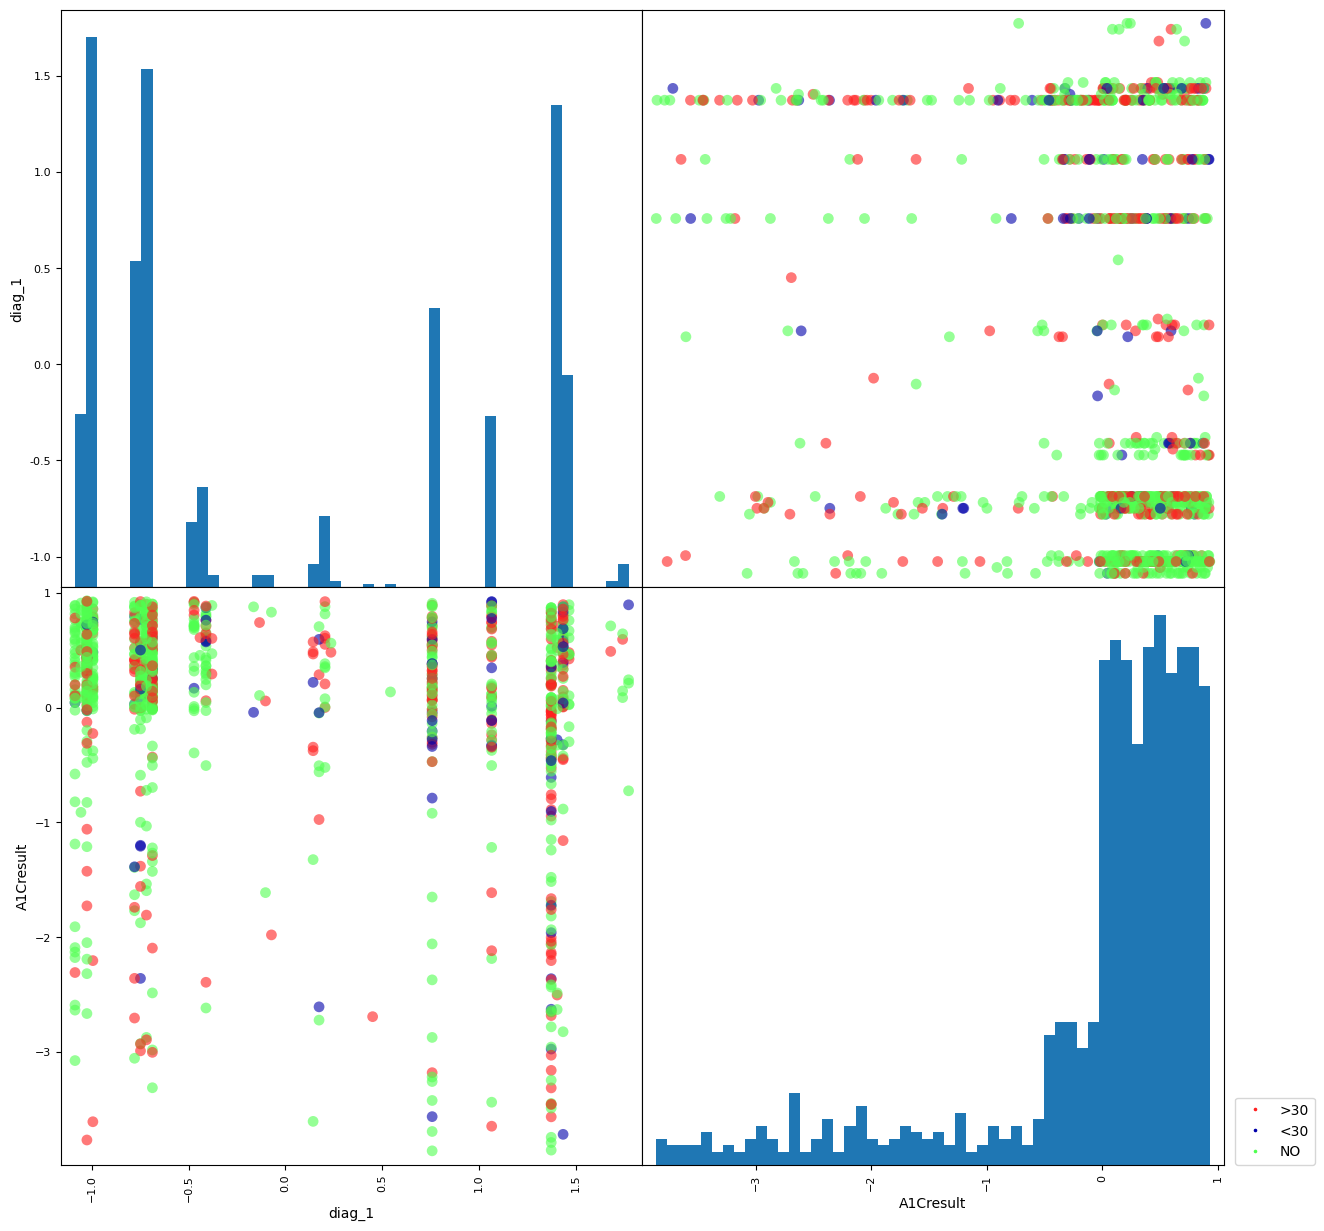

In [102]:
print("Best Parameters:", grid_search.best_params_) 
print("Best Score:", grid_search.best_score_)
#Evaluating the best model using cross-validation: assess model's performance more robustly by training and validating it 
# on different subsets of the data.
cross_val_scores = cross_val_score(grid_search.best_estimator_,X_test_scaled,y_test,cv=3,scoring='accuracy')
print("Cross-Validation Test Accuracy:", np.mean(cross_val_scores))
# Variance: Measure that helps you understand how much model's performance is spread out or varies across different subsets 
# of data.
print("Variance: ",np.var(cross_val_scores))
#Calculating the Logarithmic Loss/log_loss: measures performance of classifier where input is are probabilities, 
# between 0 and 1 and the output is the difference between the predicted probability distribution and the actual distribution of the outcomes.
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)
log_loss_scores = log_loss(y_test,y_pred_proba)
print("Logarithmic Loss:", log_loss_scores)
# Draw a matrix of scatter plots from the dataframe and color by y_train
X_train_dataframe = pd.DataFrame(X_train_scaled, columns=['diag_1', 'A1Cresult'])
y_train_dataframe = pd.DataFrame(y_train, columns=['readmitted'])['readmitted'].apply(map_readmission)
pd.plotting.scatter_matrix(X_train_dataframe, c=y_train_dataframe.values, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 50}, s=60, alpha=.6, cmap=mglearn.cm3)
handles = [plt.plot([],[],color=list(reversed(mglearn.cm3.colors))[i], ls="", marker=".", markersize=np.sqrt(10))[0] for i in range(3)]
labels=['>30', '<30', 'NO']
plt.legend(handles, labels, loc=(1.02,0))
plt.show()

### Cross validation

Accuracy on training set: 0.63
Accuracy on test set: 0.65


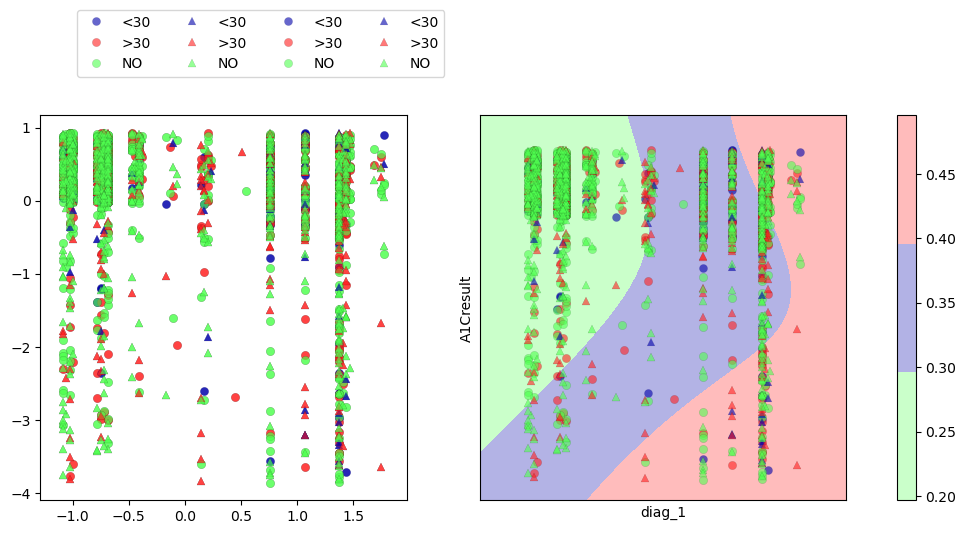

In [116]:
mlp = MLPClassifier(solver='sgd', activation=grid_search.best_params_['activation'], 
                    alpha=grid_search.best_params_['alpha'], random_state=0, hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'], 
                    max_iter=grid_search.best_params_['max_iter']).fit(X_train_scaled, y_train)
# #MLP NN Learned non-linear and ragged decision boundary => model complexity high
# mglearn.plots.plot_2d_classification(mlp, scaler.fit_transform(X), fill=True, alpha=.3)
# Uncertainty estimates of predictions
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], y_train, markers='o', alpha=.6, s=6, markeredgewidth=.1, ax=axes[0], 
                         c=[ list(reversed(mglearn.cm3.colors))[1], list(reversed(mglearn.cm3.colors))[0], list(reversed(mglearn.cm3.colors))[2]])
mglearn.discrete_scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_test, markers='^', alpha=.6, s=6, markeredgewidth=.1, ax=axes[0], 
                         c=[ list(reversed(mglearn.cm3.colors))[1], list(reversed(mglearn.cm3.colors))[0], list(reversed(mglearn.cm3.colors))[2]])
scores_image = mglearn.tools.plot_2d_scores(mlp, scaler.fit_transform(X), ax=axes[1], alpha=.3, cm=mglearn.cm3, function='predict_proba')
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], y_train, markers='o', alpha=.6, s=6, markeredgewidth=.1, ax=ax, 
                             c=[ list(reversed(mglearn.cm3.colors))[1], list(reversed(mglearn.cm3.colors))[0], '#50ff50'])
    mglearn.discrete_scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_test, markers='^', alpha=.6, s=6, markeredgewidth=.1, ax=ax, 
                             c=[ list(reversed(mglearn.cm3.colors))[1], list(reversed(mglearn.cm3.colors))[0], list(reversed(mglearn.cm3.colors))[2]])
    plt.xlabel("diag_1")
    plt.ylabel("A1Cresult")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(ncol=4, loc=(.1, 1.1))
# # #Accuracy of the MLP is quite good, but not as good as the other models. Likely due to scaling of the data.
# # #NN expect all input features to vary in a similar way, and ideally to have a mean=0, and variance=1.
print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_scaled, y_test)))

# Conclusion

- ANN trained
- Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'max_iter': 2000, 'solver': 'sgd'}
- Best Score: 0.6283816425120774
- Cross-Validation Test Accuracy: 0.65
- - ANN predicted correctly 65% of the time.
- Variance:  2.32e-07
- - Low variance suggest good consitent and prediction accross training and test set 
- Logarithmic Loss: 0.81, indicates that probabilities are not very aligned with actual outcomes. Lower log loss values are better, with 0 indicating a perfect model. 0.81 suggests a considerable level of uncertainty in the predictions, as supported by the predicted probabilty map. 